In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [26]:
df = pd.read_csv("csv_files/baldurs_gate3.csv")

df = df.dropna(subset=['review', 'labels'])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['review'].tolist(), df['labels'].tolist(), test_size=0.2, random_state=42
)

print(train_texts)

['yes   it s early access    yes   it s get a lot of promise    great graphic   amazing environment   killer first hour or so    and then your ship crash and you find yourself in the most generic rpg of        bland character   insultingly generic story quest   unbalanced repetitive combat   nightmare of inventory management   atrocious load time    those be all fundamental issue that be far beyond bug and glitch and crash you d expect from an alpha title    in your first battle   combat seem to have so much depth   so many class   ability   item   a few combat later   and it s yet another slog of range miss while the entire battlefield and everyone on it be on fire    the intro mission be so fresh   awesome baddie   incredible setting   and then bam   you re right back to find yourself shipwreck on a beach   I wish I be kid   and fight goblin and bandit in a cave    there s so much to the world   so much that you get overwhemle with a million unmarked container everywhere you have to 

In [27]:
# Model ve tokenizer tanımı
model_name = "xlnet-base-cased"  
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize etme işlemi
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

c:\Users\Emre\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Emre\.cache\huggingface\hub\models--xlnet-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [28]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Eğitim ve doğrulama veri setlerini oluşturma
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)


In [29]:
# Model tanımlama
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Ensure model and inputs are on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Eğitim ayarları
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

# Değerlendirme metrikleri
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds),
        "roc_auc": roc_auc_score(labels, preds),
    }

# Trainer API kullanarak model eğitimi
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


# Model eğitimi
start_time = time.time()
trainer.train()
training_time = time.time() - start_time
print(f"Eğitimin tamamlanması için geçen süre: {training_time:.2f} saniye")


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
# Modeli test veri setinde değerlendirme
results = trainer.evaluate()
print("Model Değerlendirme Sonuçları:", results)


  0%|          | 0/13 [00:00<?, ?it/s]

Model Değerlendirme Sonuçları: {'eval_loss': 0.13266615569591522, 'eval_accuracy': 0.965, 'eval_precision': 0.9846938775510204, 'eval_recall': 0.9796954314720813, 'eval_f1': 0.9821882951653944, 'eval_roc_auc': 0.48984771573604063, 'eval_runtime': 3.3428, 'eval_samples_per_second': 59.831, 'eval_steps_per_second': 3.889, 'epoch': 3.0}


In [ ]:
from torch.utils.data import DataLoader

# Create a DataLoader for the validation dataset
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


print("\nÇıkarım (Inference) süresi hesaplanıyor...")

model.eval()  # Evaluation mode

# Inference Time Calculation
start_inference_time = time.time()

with torch.no_grad():  # Disable gradient calculations
    for batch in val_loader:  # Use DataLoader to get batches
        batch = {k: v.to(device) for k, v in batch.items()}  # Move data to GPU/CPU
        outputs = model(**batch)

end_inference_time = time.time()

# Inference time summary
total_inference_time = end_inference_time - start_inference_time
num_samples = len(val_dataset)  # Total number of samples
average_inference_time = total_inference_time / num_samples

print(f"Toplam çıkarım süresi: {total_inference_time:.2f} saniye")
print(f"Veri başına ortalama çıkarım süresi: {average_inference_time:.6f} saniye")



Çıkarım (Inference) süresi hesaplanıyor...
Toplam çıkarım süresi: 2.87 saniye
Veri başına ortalama çıkarım süresi: 0.014355 saniye


  0%|          | 0/13 [00:00<?, ?it/s]

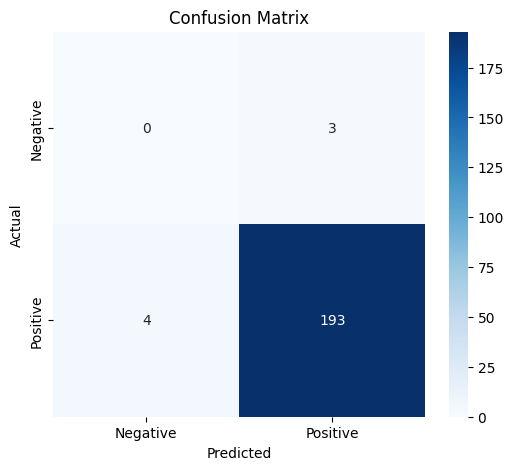

In [ ]:
# Karmaşıklık Matrisi ve ROC Eğrisi
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids  # True labels
y_probs = predictions.predictions[:, 1]  # Probabilities for ROC-AUC

# Confusion Matrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Negative", "Positive"], 
            yticklabels=["Negative", "Positive"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

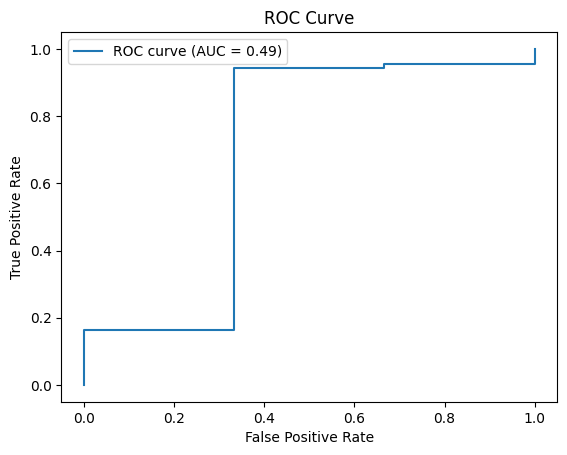

In [ ]:
# ROC Eğrisi
fpr, tpr, _ = roc_curve(labels, y_probs)
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (AUC = {:.2f})".format(roc_auc_score(labels, preds)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [10]:
tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()

# Calculate Metrics
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)  # Same as Sensitivity
specificity = tn / (tn + fp)  # True Negative Rate
f1 = f1_score(labels, preds)
roc_auc = roc_auc_score(labels, y_probs)

# Create DataFrame with All Metrics
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall (Sensitivity)", "Specificity", "F1-Score", "ROC-AUC"],
    "Score": [accuracy, precision, recall, specificity, f1, roc_auc]
})

# Display the DataFrame
print(metrics_df)

                 Metric     Score
0              Accuracy  0.965000
1             Precision  0.984694
2  Recall (Sensitivity)  0.979695
3           Specificity  0.000000
4              F1-Score  0.982188
5               ROC-AUC  0.686971


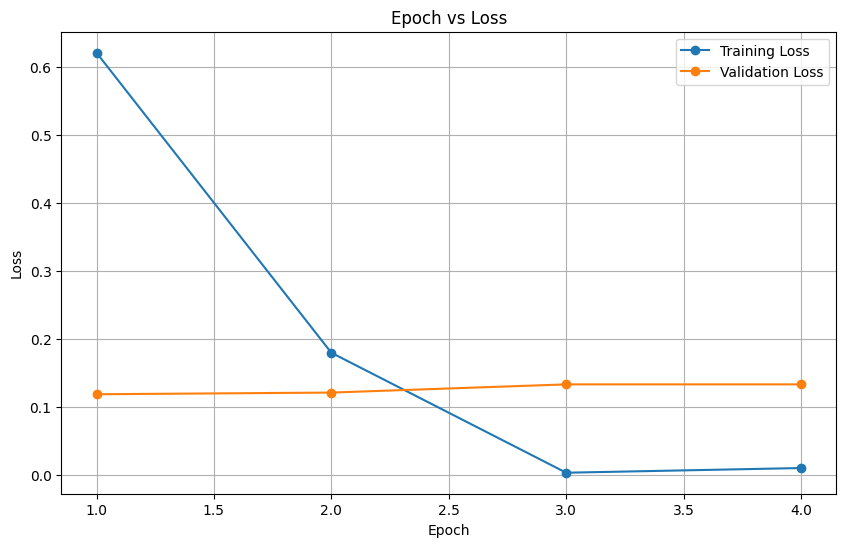

In [ ]:


# Extract training and evaluation loss
train_losses = []
eval_losses = []
epochs = []

epoch_count = 0

# Collect only valid losses at the end of each epoch
for log in trainer.state.log_history:
    if "loss" in log:  # Training loss
        train_losses.append(log["loss"])
    if "eval_loss" in log:  # Evaluation loss
        eval_losses.append(log["eval_loss"])
        epoch_count += 1  # Increment epoch only when eval_loss is logged
        epochs.append(epoch_count)

# Align Training Losses with Evaluation Losses
# Keep only one training loss per epoch if there are extra points
if len(train_losses) > len(eval_losses):
    train_losses = train_losses[:len(eval_losses)]
elif len(eval_losses) > len(train_losses):
    eval_losses = eval_losses[:len(train_losses)]

# Plot Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker="o")
plt.plot(epochs, eval_losses, label="Validation Loss", marker="o")

plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()
